In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

In [3]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.7.0+cu126
0.22.0+cpu


In [129]:
class RGBAImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png') or f.endswith('.jpg')]
        self.real_len = len(self.image_files)

    def __len__(self):
        return self.real_len*100

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx%real_len])
        # image = Image.open(img_path).convert('RGBA')  # Ensure RGBA format
        image = Image.open(img_path).convert('RGBA')  # Ensure RGBA format
        if self.transform:
            image = self.transform(image)
        return image

In [18]:
dataset = RGBAImageDataset(root_dir='images')

In [20]:
len(dataset)

523

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

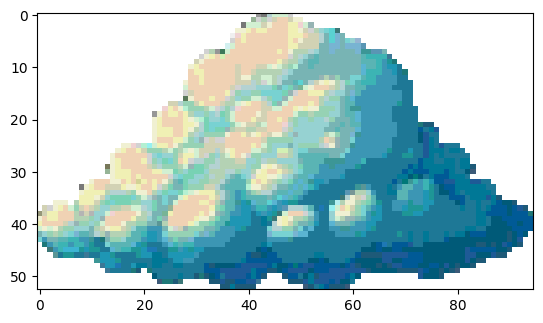

In [24]:
plt.imshow(dataset[1])

In [113]:
transform = transforms.Compose([
            transforms.CenterCrop((93,261)),
            transforms.RandomAffine(0,translate=(5/261,5/93))
])

In [119]:
transform = transforms.Compose([
            transforms.CenterCrop((93,261)),
            transforms.RandomAffine(0,translate=(5/261,5/93)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
])

In [120]:
dataset = RGBAImageDataset(root_dir='images', transform=transform)

In [121]:
dataset[1][3][50]

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -

In [128]:
dataset[1].shape

torch.Size([4, 93, 261])

In [116]:
dataset[1].size

(261, 93)

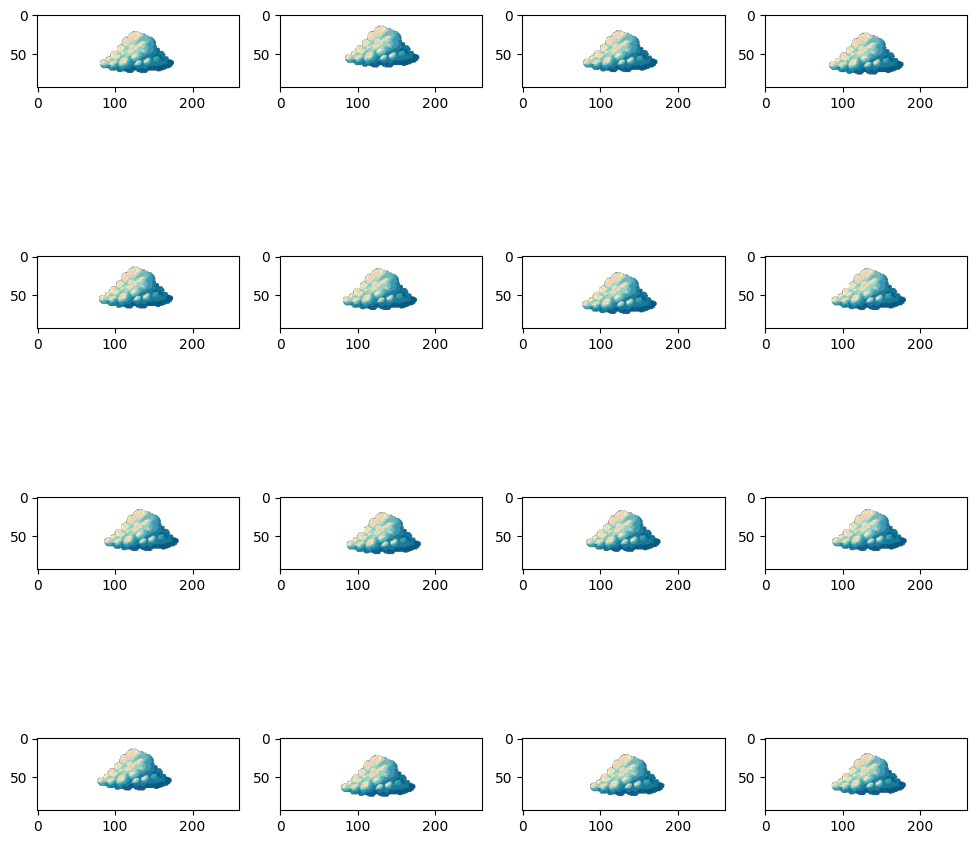

In [117]:
plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(dataset[1])

In [132]:
5203%523

496

In [2]:
import torch.nn as nn

In [135]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=4, stride=2, padding=1) # Output: 64x64
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1) # Output: 32x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # Output: 16x16
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # Output: 8x8
        self.lin1 = nn.Linear(128 * 8 * 8, 1)  # Corrected linear layer input size

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view(-1, 128 * 8 * 8)  # Flatten before linear layer
        return torch.sigmoid(self.lin1(x))  # Sigmoid for probability output


class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 8*8*256) # Adjust for 128x128 output
        self.ct1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1) # Upsample to 16x16
        self.ct2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)  # Upsample to 32x32
        self.ct3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)   # Upsample to 64x64
        self.ct4 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)   # Upsample to 128x128
        self.conv = nn.Conv2d(16, 4, kernel_size=3, padding=1) # Output 4 channels

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 256, 8, 8)

        x = self.ct1(x)
        x = F.relu(x)

        x = self.ct2(x)
        x = F.relu(x)

        x = self.ct3(x)
        x = F.relu(x)

        x = self.ct4(x)
        x = F.relu(x)

        return torch.tanh(self.conv(x)) # Tanh for normalization to [-1, 1]

In [137]:
print(Discriminator())

Discriminator(
  (conv1): Conv2d(4, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (lin1): Linear(in_features=8192, out_features=1, bias=True)
)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [39]:

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 4, 4, 2, 1, bias=False),  # Output channel = 4
            nn.Tanh()  # Output range -1 to 1
        )

    def forward(self, x):
        return self.model(x)

In [41]:
# Example usage:
latent_dim = 100
generator = Generator(latent_dim)
latent_vector = torch.randn(1, latent_dim, 1, 1)  # Example latent vector
output = generator(latent_vector)
print(output.shape)  # Check output shape

torch.Size([1, 4, 32, 32])


In [88]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Calculate the initial size needed to get to 261x93
        # We'll start with a smaller feature map and upsample
        self.lin1 = nn.Linear(latent_dim, 32 * 4 * 3)  # Adjust for initial size
        self.ct1 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1) # Upsample to 8x6
        self.ct2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=3, padding=1)  # Upsample to 24x18
        self.ct3 = nn.ConvTranspose2d(16, 8, kernel_size=5, stride=4, padding=1)   # Upsample to 93x69
        self.ct4 = nn.ConvTranspose2d(8, 4, kernel_size=5, stride=3, padding=1)   # Upsample to 277x205
        self.conv = nn.Conv2d(4, 4, kernel_size=1, padding=0)  # Output 3 channels (RGB), adjust padding

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 32, 4, 3) # Reshape to the calculated initial size

        x = self.ct1(x)
        x = F.relu(x)

        x = self.ct2(x)
        x = F.relu(x)

        x = self.ct3(x)
        x = F.relu(x)

        x = self.ct4(x)
        x = F.relu(x)

        x = self.conv(x)
        return torch.tanh(x[:, :, :261, :93])  # Crop to 261x93


In [42]:
latent_dim = 1
generator = Generator(latent_dim)
latent_vector = torch.randn(1, latent_dim)  # Example latent vector
output = generator(latent_vector)
print(output.shape)  # Check output shape

output[0]

torch.Size([1, 4, 125, 269])


tensor([[[ 2.1587e-01,  2.1158e-01,  2.1564e-01,  ...,  2.1491e-01,
           2.2035e-01,  2.1500e-01],
         [ 2.1777e-01,  2.1533e-01,  2.2255e-01,  ...,  2.1542e-01,
           2.1310e-01,  2.1150e-01],
         [ 2.1529e-01,  2.1498e-01,  2.1805e-01,  ...,  2.1720e-01,
           2.2471e-01,  2.1395e-01],
         ...,
         [ 2.1251e-01,  2.1619e-01,  2.1309e-01,  ...,  2.1366e-01,
           2.2197e-01,  2.1338e-01],
         [ 2.2122e-01,  2.1692e-01,  2.2585e-01,  ...,  2.2104e-01,
           2.1315e-01,  2.1682e-01],
         [ 2.1358e-01,  2.1230e-01,  2.1102e-01,  ...,  2.1171e-01,
           2.1812e-01,  2.1454e-01]],

        [[ 4.3996e-01,  4.3890e-01,  4.3895e-01,  ...,  4.4244e-01,
           4.4178e-01,  4.4322e-01],
         [ 4.3999e-01,  4.4221e-01,  4.4100e-01,  ...,  4.4256e-01,
           4.3901e-01,  4.4223e-01],
         [ 4.4014e-01,  4.3633e-01,  4.3989e-01,  ...,  4.4464e-01,
           4.4014e-01,  4.4415e-01],
         ...,
         [ 4.3978e-01,  4

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 16 * 4 ),
            nn.ReLU(),
            nn.Linear(16*4, 32 * 4 ),
            nn.ReLU(),
            nn.Unflatten(1, (32, 1, 4)),  # Reshape
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=3, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(4, 4, kernel_size=1, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
latent_dim = 100
generator = Generator(latent_dim)
latent_vector = torch.rand(1, latent_dim)  # Example latent vector
output = generator(latent_vector)
print(output.shape)  # Check output shape
print(output[0][0][0][0], output[0][0][0][0], output[0][0][0][0])

torch.Size([1, 4, 125, 269])
tensor(0.5042, grad_fn=<SelectBackward0>) tensor(0.5042, grad_fn=<SelectBackward0>) tensor(0.5042, grad_fn=<SelectBackward0>)


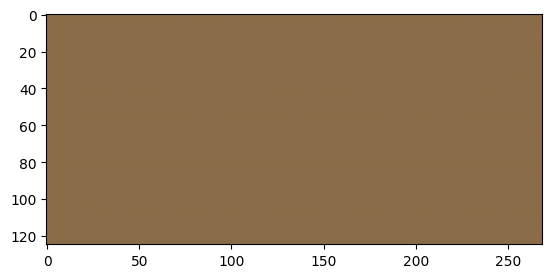

In [13]:
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage(mode='RGBA')
plt.imshow(to_img(output[0]))

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential()
        self.model.append( nn.Conv2d(4, 16, kernel_size=4, stride=2, padding=1) )  # Output: 63x134
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1) )  # Output: 32x67
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) )  # Output: 16x34
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) ) # Output: 8x17
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) ) # Output: 4x9
        self.model.append( nn.LeakyReLU(0.2) )
        self.model.append( nn.Flatten() )
        self.model.append( nn.Linear(6144, 1) )  # Corrected input size
        self.model.append( nn.Sigmoid() )
        
    def forward(self, x):
        return self.model(x)

In [32]:
discriminator = Discriminator()
d_output = discriminator(output)
print(d_output.shape) # Should be torch.Size([1, 1])
print(d_output) # Should be torch.Size([1, 1])

torch.Size([1, 1])
tensor([[0.4952]], grad_fn=<SigmoidBackward0>)


In [36]:

for layer in discriminator.model.children():
    print (layer, type(layer), hasattr(layer,'reset_parameters'))
    if hasattr(layer,'reset_parameters'):
        layer.reset_parameters()



Conv2d(4, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) <class 'torch.nn.modules.conv.Conv2d'> True
LeakyReLU(negative_slope=0.2) <class 'torch.nn.modules.activation.LeakyReLU'> False
Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) <class 'torch.nn.modules.conv.Conv2d'> True
LeakyReLU(negative_slope=0.2) <class 'torch.nn.modules.activation.LeakyReLU'> False
Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) <class 'torch.nn.modules.conv.Conv2d'> True
LeakyReLU(negative_slope=0.2) <class 'torch.nn.modules.activation.LeakyReLU'> False
Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) <class 'torch.nn.modules.conv.Conv2d'> True
LeakyReLU(negative_slope=0.2) <class 'torch.nn.modules.activation.LeakyReLU'> False
Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) <class 'torch.nn.modules.conv.Conv2d'> True
LeakyReLU(negative_slope=0.2) <class 'torch.nn.modules.activation.LeakyReLU'> False
Flatten(start_dim=1, end_dim

In [37]:
def cosine_decay_with_warmup(cur_nimg, base_value, total_nimg, final_value=0.0):
    decay = 0.5 * (1 + np.cos(np.pi * (cur_nimg) / float(total_nimg)))
    cur_value = base_value + (1 - decay) * (final_value - base_value)
    return float(np.where(cur_nimg > total_nimg, final_value, cur_value))

In [41]:
curr_nimg = 0
for i in range(11):
    print (curr_nimg, cosine_decay_with_warmup(curr_nimg, 75, 100, 7.5))
    curr_nimg += 10

0 75.0
10 73.34815742496144
20 68.55432356015447
30 61.08775226487097
40 51.67932356015447
50 41.25
60 30.820676439845542
70 21.412247735129036
80 13.94567643984552
90 9.151842575038557
100 7.5
